# Campbell&ndash;Shiller decomposition of U.S. stock returns

The \cite{campbell_shiller:1988} decomposition is an approximation of an
accounting identity (under a transversality condition) that relates the
logarithm of the current price dividend ratio to present discounted value of
future dividend growth rates and future returns:
    
\begin{equation}
z_{t}=\sum_{j=1}^{\infty }\rho ^{j}g_{t+j}-\sum_{j=1}^{\infty }\rho
^{j}r_{t+j}  \label{eq:cs_z_accounting_identity}
\end{equation}

where

\begin{equation*}
z_{t}=\log \frac{Q_{t}}{G_{t}}\qquad g_{t+1}=\log \frac{G_{t+1}}{G_{t}}%
\qquad r_{t+1}=\log R_{t+1}
\end{equation*}

and the constant $\rho $ is given by

\begin{equation*}
\rho =\frac{\exp \left( \bar{z}\right) }{\exp \left( \bar{z}\right) +1}
\end{equation*}

where $\bar{z}$ is the logarithm of the steady state price dividend ratio,
which we can set to $\bar{z}=\log E\left[ Q_{t}/G_{t}\right] $.

We are interested in understanding whether movements in the price-dividend
ratio are more associated with changes in future returns or future growth
rates. For that, we compute the covariance of equation (\ref%
{eq:cs_z_accounting_identity}) with $z_{t}$, to obtain

\begin{equation*}
Var\left( z_{t}\right) =Cov\left( z_{t},\sum_{j=1}^{\infty }\rho
^{j}g_{t+j}\right) +Cov\left( z_{t},-\sum_{j=1}^{\infty }\rho
^{j}r_{t+j}\right)
\end{equation*}

and, dividing by $Var\left( z_{t}\right) $,

\begin{equation*}
1=\frac{Cov\left( z_{t},\sum_{j=1}^{\infty }\rho ^{j}g_{t+j}\right) }{%
Var\left( z_{t}\right) }+\frac{Cov\left( z_{t},-\sum_{j=1}^{\infty }\rho
^{j}r_{t+j}\right) }{Var\left( z_{t}\right) }.
\end{equation*}

In order to implement this equation empirically, we need to truncate the
infinite sum with a finite horizon $J$

\begin{equation}
1=\frac{Cov\left( z_{t},\sum_{j=1}^{J}\rho ^{j}g_{t+j}\right) }{Var\left(
z_{t}\right) }+\frac{Cov\left( z_{t},-\sum_{j=1}^{J}\rho ^{j}r_{t+j}\right)
}{Var\left( z_{t}\right) }.  \label{eq:cs_decomposition}
\end{equation}

## Implementation

We implement the decomposition using data from <a href="http://www.econ.yale.edu/~shiller/data.htm">Robert Shiller website</a>.

In [1]:
# import some useful predefined functions from the course package
from course import *

Done everything.


Download and process price and dividend data.

In [2]:
# download data from Robert Shiller's website
data_Shiller = pd.read_excel("http://www.econ.yale.edu/~shiller/data/ie_data.xls",sheet_name="Data",header=7)

In [3]:
# process data
data = data_Shiller[["Date","Price","Dividend","Price.1","Earnings"]]
data.columns = ["Date","Price","Dividend","Cumulative Return","Earnings"]
data = data[~np.isnan(data["Price"] + data["Dividend"] + data["Cumulative Return"])]
data.insert(5,"PD ratio",data["Price"]/(data["Dividend"]/12))

First plot the data.

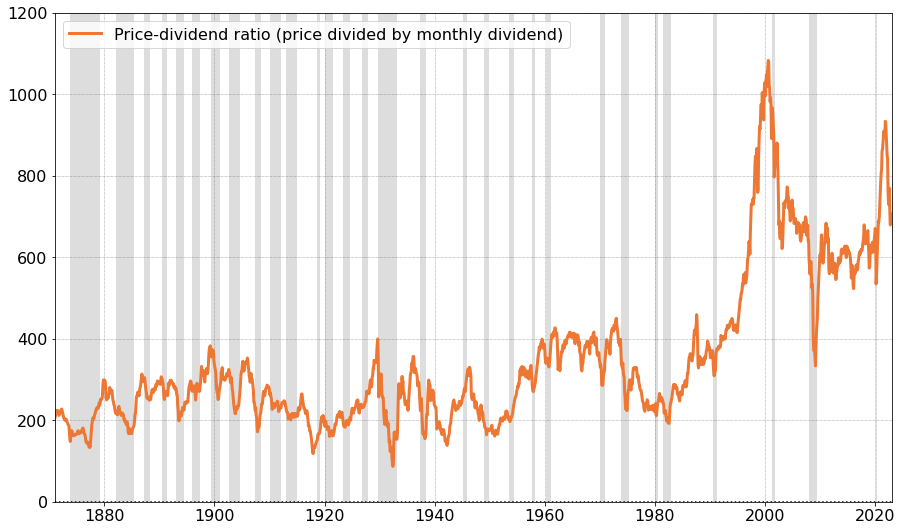

In [4]:
fig_param = {'figsize' : [15,9], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [1871,2023], 'ylim': [0,1200],
         'xlabel': '', 'ylabel': '',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [0,1200]}
    
fig,ax = myGenerateTSPlot(fig_param)

ax.plot(data["Date"]//1 + ((data["Date"]%1 * 100)-1)/12,data["PD ratio"],
             linewidth=3,color=myColor['tolVibrantOrange'],label='Price-dividend ratio (price divided by monthly dividend)')
ax.legend(loc="upper left")

fig.savefig('graphs/perturbation_campbell_shiller_PD_ratio.pdf',bbox_inches='tight')

Construct a function that produces the Cambell-Shiller decomposition.

In [5]:
def CS_decomposition(data,Jmax):
    
    R = np.float64(data.loc[data.index[1:],"Cumulative Return"]) / np.float64(data.loc[data.index[0:-1],"Cumulative Return"])
    G = np.float64(data.loc[data.index[1:],"Dividend"]) / np.float64(data.loc[data.index[0:-1],"Dividend"])
    Z = np.float64(data["PD ratio"])

    r = np.log(R)
    g = np.log(G)
    z = np.log(Z)
    
    T = len(R)

    c_g, c_r = np.zeros(Jmax), np.zeros(Jmax)

    rho = Z.mean() / (Z.mean() + 1)
    rho_series = rho ** np.linspace(0,Jmax,Jmax+1)

    partsum_g = np.zeros(T)
    partsum_r = np.zeros(T)


    for J in range(Jmax):
        for t in range(T-J):
            partsum_g[t] = sum(rho_series[1:J+2]*g[t:t+J+1])
            partsum_r[t] = sum(rho_series[1:J+2]*r[t:t+J+1])
    
        var_z = z[0:T-J].var()
        
        c_g[J] = np.cov([z[:T-J],partsum_g[:T-J]])[0,1] / var_z
        c_r[J] = np.cov([z[:T-J],-partsum_r[:T-J]])[0,1] / var_z
    
    return c_g, c_r

Call functions for two different samples.

In [6]:
Jmax = 300

c_g, c_r = CS_decomposition(data,Jmax)
c_g_shorter, c_r_shorter = CS_decomposition(data[data["Date"] < 1990],Jmax)

Plot decompositions.

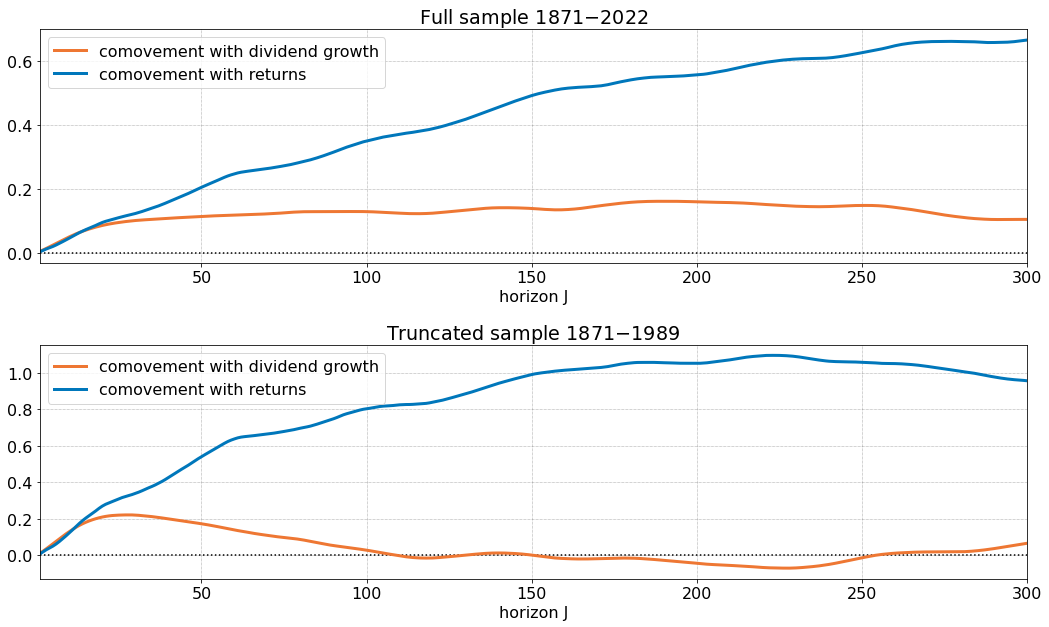

In [7]:
fig_param = {'figsize' : [15,9], 'fontsize': 16, 'subplots': [2,1],
         'title': '',
         'xlim': [1,Jmax], 'ylim': [0,0],
         'xlabel': 'horizon J', 'ylabel': '',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,1200]}
    
fig,ax = myGenerateTSPlot(fig_param)

ax[0,0].plot(np.linspace(1,Jmax,Jmax),c_g,linewidth=3,color=myColor['tolVibrantOrange'],label='comovement with dividend growth')
ax[0,0].plot(np.linspace(1,Jmax,Jmax),c_r,linewidth=3,color=myColor['tolVibrantBlue'],label='comovement with returns')
ax[0,0].set_title(f'Full sample {int(data.loc[0,"Date"]//1)}$-${int(data.loc[data.index[-1],"Date"]//1)}')
ax[0,0].legend(loc="upper left")

ax[1,0].plot(np.linspace(1,Jmax,Jmax),c_g_shorter,linewidth=3,color=myColor['tolVibrantOrange'],label='comovement with dividend growth')
ax[1,0].plot(np.linspace(1,Jmax,Jmax),c_r_shorter,linewidth=3,color=myColor['tolVibrantBlue'],label='comovement with returns')
ax[1,0].set_title(f'Truncated sample {int(data.loc[0,"Date"]//1)}$-${int(data[data["Date"] < 1990].loc[data[data["Date"] < 1990].index[-1],"Date"]//1)}')
ax[1,0].legend(loc="upper left")

fig.tight_layout()
fig.savefig('graphs/perturbation_campbell_shiller_decomposition.pdf',bbox_inches='tight')